# Regrid between curvilinear grids


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

## Prepare data


### Input data


Here we regrid the built-in "rasm" demo data. This data is used by another
[xarray tutorial](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html#examples-multidim).


In [2]:
ds = xr.tutorial.open_dataset(
    "rasm"
)  # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 288B 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 451kB ...
    yc       (y, x) float64 451kB ...
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 16MB ...
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

It is the surface air temperature data, with `nan` over the ocean.


In [3]:
dr = ds["Tair"]
dr

<xarray.DataArray 'Tair' (time: 36, y: 205, x: 275)> Size: 16MB
[2029500 values with dtype=float64]
Coordinates:
  * time     (time) object 288B 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 451kB ...
    yc       (y, x) float64 451kB ...
Dimensions without coordinates: y, x
Attributes:
    units:           C
    long_name:       Surface air temperature
    type_preferred:  double
    time_rep:        instantaneous

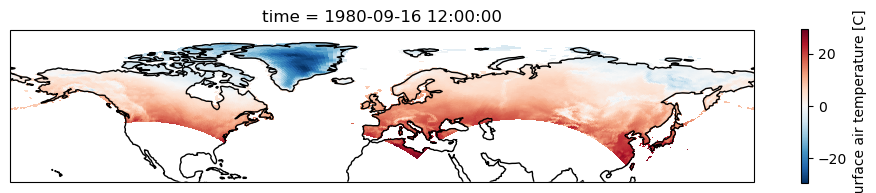

In [4]:
plt.figure(figsize=(12, 2))
ax = plt.axes(projection=ccrs.PlateCarree())
dr[0].plot.pcolormesh(ax=ax, x="xc", y="yc")
ax.coastlines()

### Input grid


`xc` and `yc` are longitude and latitude values. They are both 2D arrays,
describing a curvilinear grid over high-latitudes. Note that it is totally fine
for a grid to span over the south or north pole. ESMF performs regridding in the
Cartesian space (x, y, z) so there will be no polar singularities.


Text(0, 0.5, 'lat')

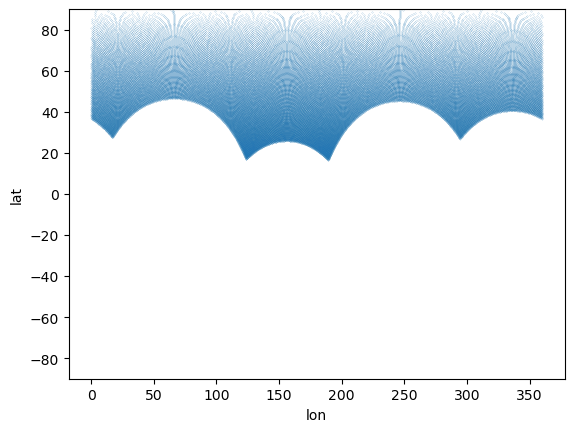

In [5]:
plt.scatter(ds["xc"], ds["yc"], s=0.01)  # plot grid locations
plt.ylim([-90, 90])
plt.xlabel("lon")
plt.ylabel("lat")

We need to rename the coordinate names to `lon` and `lat` because xESMF has no
way to guess variable meaning.


In [6]:
ds = ds.rename({"xc": "lon", "yc": "lat"})
ds

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 288B 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    lon      (y, x) float64 451kB 189.2 189.4 189.6 189.7 ... 17.4 17.15 16.91
    lat      (y, x) float64 451kB 16.53 16.78 17.02 17.27 ... 28.01 27.76 27.51
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 16MB ...
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

### Output grid


Say we want to regrid it to a global $4^\circ \times 5^\circ$ grid. xESMF
provides a shortcut to make this output grid.


In [7]:
ds_out = xe.util.grid_global(5, 4)
ds_out  # contains lat/lon values of cell centers and boundaries.

<xarray.Dataset> Size: 106kB
Dimensions:  (y: 45, x: 72, y_b: 46, x_b: 73)
Coordinates:
    lon      (y, x) float64 26kB -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    lat      (y, x) float64 26kB -88.0 -88.0 -88.0 -88.0 ... 88.0 88.0 88.0 88.0
    lon_b    (y_b, x_b) float64 27kB -180.0 -175.0 -170.0 ... 170.0 175.0 180.0
    lat_b    (y_b, x_b) float64 27kB -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

The output coordinates are all 2D arrays. They happen to be a rectilinear grid
in this case (`lat` is constant over `x` axis, and `lon` is constant over `y`
axis), but you can use 2D arrays to specify any curvilinear grids.


## Perform regridding


Regridding is straightforward, just like the previous example.


In [8]:
regridder = xe.Regridder(ds, ds_out, "bilinear")
dr_out = regridder(dr)

## Check results


Extra dimensions and coordinate values are all correct, like in the previous
example.


In [9]:
dr_out

<xarray.DataArray (time: 36, y: 45, x: 72)> Size: 933kB
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(36, 45, 72))
Coordinates:
  * time     (time) object 288B 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    lon      (y, x) float64 26kB -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    lat      (y, x) float64 26kB -88.0 -88.0 -88.0 -88.0 ... 88.0 88.0 88.0 88.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

The regridding result is consistent with the original data, but now on a
rectilinear grid with a coarser resolution. `nan` is mapped to `nan`.


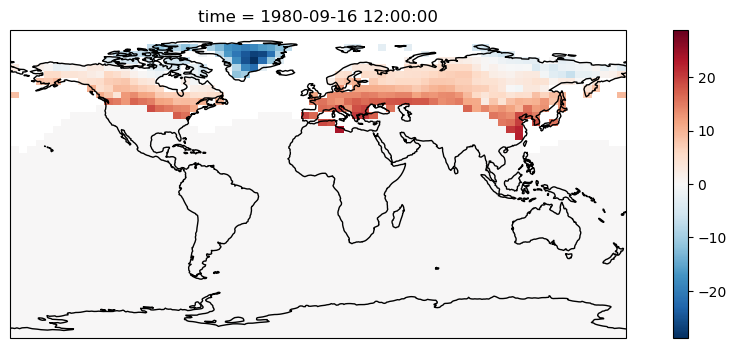

In [10]:
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out[0].plot.pcolormesh(ax=ax, x="lon", y="lat")
ax.coastlines()

## Undesired extrapolation 
### when using the `nearest_s2d` method

This section is a short excursion into the masking topic specifically for regional (often curvilinear) source grids. General guidance regarding masking can be found in the general [Masking](Masking.ipynb) section.

When remapping to a larger domain with the `nearest_s2d` method, target grid cells outside the original source domain will get the value of the closest source grid cell at the domain edge, owed to the logic behind the `nearest_s2d` algorithm.

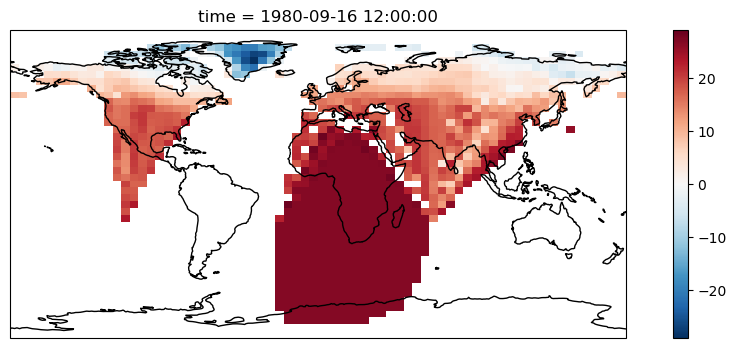

In [11]:
# Compute remapping weights with method `nearest_s2d`
regridder_nearest = xe.Regridder(ds, ds_out, "nearest_s2d")

# Remap the data
dr_out = regridder_nearest(dr)

# Plot the result
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out[0].plot.pcolormesh(ax=ax, x="lon", y="lat")
ax.coastlines()

If this is undesired, it can be avoided by including the arguments `post_mask_source="domain_edge"` 
(and optionally `unmapped_to_nan=True` if all unmapped cells should be set to NaN rather than zero) when generating the remapping weights.
This will alter the remapping weights **after** their generation to remove the contribution
of the outermost source grid cells of the original domain (i.e. the source grid cells at the domain edge). 

**Note:** While this prevents the often undesired extrapolation artifacts outside the original domain, 
this means that the information of the source grid cells at the domain edge will be lost in the remapped data.

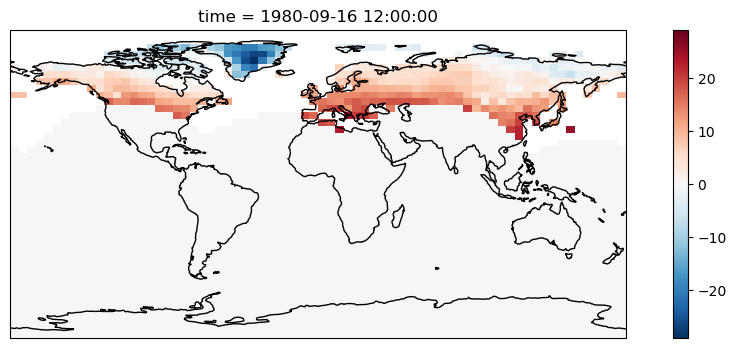

In [12]:
# Compute remapping weights with method `nearest_s2d`
regridder_nearest = xe.Regridder(
    ds, ds_out, "nearest_s2d", post_mask_source="domain_edge"
)

# Remap the data
dr_out = regridder_nearest(dr)

# Plot the result
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out[0].plot.pcolormesh(ax=ax, x="lon", y="lat")
ax.coastlines()

Alternatively, one can specify a tailored mask for the target grid. If there is no tailored mask at hand, one could generate it from the bilinear weights:
- Generate mask from the bilinear regridding weights (created with active `unmapped_to_nan` option!)

In [13]:
# Generate weights
regridder = xe.Regridder(ds, ds_out, "bilinear", unmapped_to_nan=True)

# Generate mask from this weights
mask = xe.smm.gen_mask_from_weights(regridder.weights, nlat=45, nlon=72)

- Add the mask to the output `xarray.Dataset`

In [14]:
ds_out["mask"] = xr.DataArray(dims=("y", "x"), data=mask)

- Conduct the remapping as usual

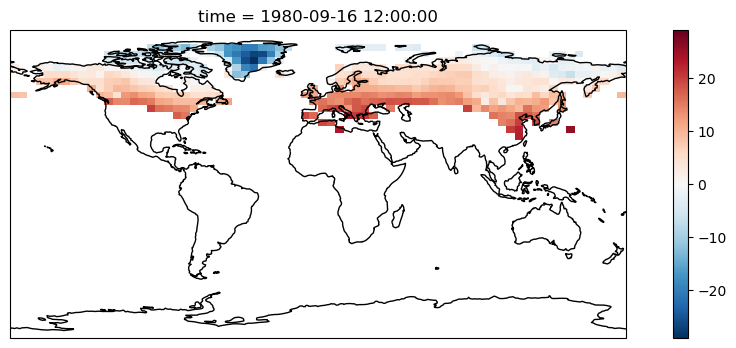

In [15]:
# Compute remapping weights with method `nearest_s2d`
regridder_nearest = xe.Regridder(ds, ds_out, "nearest_s2d")

# Remap the data
dr_out = regridder_nearest(dr)

# Plot the result
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out[0].plot.pcolormesh(ax=ax, x="lon", y="lat")
ax.coastlines()